# Run First Models

In [1]:
import pathlib
import sys
import pickle

from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# add the 'src' directory to path to import modules
src_dir = pathlib.Path().cwd().resolve().parent / 'src'
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(str(src_dir))
# import my class code from the source
# %aimport src-dir.filename
from data.data_process import transform_ts_to_supervised

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import keras

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

PROJECT_DIR = pathlib.Path.cwd().resolve().parent
CONSOL_DATA_DIR = PROJECT_DIR / 'data' / '07-consolidated'

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
fp = CONSOL_DATA_DIR / 'epl.csv'
df = pd.read_csv(fp, index_col=None)

In [4]:
df.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,h_htGoals,h_yellowCards,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_htGoals,a_yellowCards,h_oddsWinMean,h_oddsDrawMean,a_oddsWinMean,oddsHwinBet,oddsDrawBet,oddsAwinBet,oddsHwinPinn,oddsDrawPinn,oddsAwinPinn,oddsHwinMax,oddsDrawMax,oddsAwinMax,result,h_result,a_result,h_goalsFor,h_goalsAgainst,a_goalsFor,a_goalsAgainst,h_impliedWinProbMean,h_impliedDrawProbMean,a_impliedDrawProbMean,a_impliedWinProbMean,a_oddsDrawMean,h_h_ftGoals-0,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,h_h_ftGoals-9,h_h_ftGoals-10,h_h_ftGoals-11,h_h_ftGoals-12,h_h_ftGoals-13,h_h_ftGoals-14,h_h_ftGoals-15,h_h_ftGoals-16,h_h_ftGoals-17,h_h_ftGoals-18,a_a_ftGoals-0,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_a_ftGoals-9,a_a_ftGoals-10,a_a_ftGoals-11,a_a_ftGoals-12,a_a_ftGoals-13,a_a_ftGoals-14,a_a_ftGoals-15,a_a_ftGoals-16,a_a_ftGoals-17,a_a_ftGoals-18,a_h_ftGoals-1,a_h_ftGoals-10,a_h_ftGoals-11,a_h_ftGoals-12,a_h_ftGoals-13,a_h_ftGoals-14,a_h_ftGoals-15,a_h_ftGoals-16,a_h_ftGoals-17,a_h_ftGoals-18,a_h_ftGoals-19,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,a_h_ftGoals-9,h_a_ftGoals-1,h_a_ftGoals-10,h_a_ftGoals-11,h_a_ftGoals-12,h_a_ftGoals-13,h_a_ftGoals-14,h_a_ftGoals-15,h_a_ftGoals-16,h_a_ftGoals-17,h_a_ftGoals-18,h_a_ftGoals-19,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_a_ftGoals-9,h_h_shots-0,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,h_h_shots-9,h_h_shots-10,h_h_shots-11,h_h_shots-12,h_h_shots-13,h_h_shots-14,h_h_shots-15,h_h_shots-16,h_h_shots-17,h_h_shots-18,a_a_shots-0,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_a_shots-9,a_a_shots-10,a_a_shots-11,a_a_shots-12,a_a_shots-13,a_a_shots-14,a_a_shots-15,a_a_shots-16,a_a_shots-17,a_a_shots-18,a_h_shots-1,a_h_shots-10,a_h_shots-11,a_h_shots-12,a_h_shots-13,a_h_shots-14,a_h_shots-15,a_h_shots-16,a_h_shots-17,a_h_shots-18,a_h_shots-19,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,a_h_shots-9,h_a_shots-1,h_a_shots-10,h_a_shots-11,h_a_shots-12,h_a_shots-13,h_a_shots-14,h_a_shots-15,h_a_shots-16,h_a_shots-17,h_a_shots-18,h_a_shots-19,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_a_shots-9,h_h_shotsOnTarget-0,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,h_h_shotsOnTarget-9,h_h_shotsOnTarget-10,h_h_shotsOnTarget-11,h_h_shotsOnTarget-12,h_h_shotsOnTarget-13,h_h_shotsOnTarget-14,h_h_shotsOnTarget-15,h_h_shotsOnTarget-16,h_h_shotsOnTarget-17,h_h_shotsOnTarget-18,a_a_shotsOnTarget-0,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_a_shotsOnTarget-9,a_a_shotsOnTarget-10,a_a_shotsOnTarget-11,a_a_shotsOnTarget-12,a_a_shotsOnTarget-13,a_a_shotsOnTarget-14,a_a_shotsOnTarget-15,a_a_shotsOnTarget-16,a_a_shotsOnTarget-17,a_a_shotsOnTarget-18,a_h_shotsOnTarget-1,a_h_shotsOnTarget-10,a_h_shotsOnTarget-11,a_h_shotsOnTarget-12,a_h_shotsOnTarget-13,a_h_shotsOnTarget-14,a_h_shotsOnTarget-15,a_h_shotsOnTarget-16,a_h_shotsOnTarget-17,a_h_shotsOnTarget-18,a_h_shotsOnTarget-19,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,a_h_shotsOnTarget-9,h_a_shotsOnTarget-1,h_a_shotsOnTarget-10,h_a_shotsOnTarget-11,h_a_shotsOnTarget-12,h_a_shotsOnTarget-13,h_a_shotsOnTarget-14,h_a_shotsOnTarget-15,h_a_shotsOnTarget-16,h_a_shotsOnTarget-17,h_a_shotsOnTarget-18,h_a_shotsOnTarget-19,h_a_shotsOnTa

In [5]:
import re

def get_n_past_games(df_orig, past_games=2, dropna_rows=True):
    """
    Restrict historical records to the last n games
    If n = 2, then will get
    home team
        last 2 games played at home ie. h_h_feature-1, h_h_feature-2
        last 2 games played away ie h_a_feature-1, h_a_feature-2
    away team
        last 2 games played at home ie a_h_feature-1, a_h_feature-2
        last 2 games played away ie a_a_feature-1, a_a_feature-2
    where -1 is the most recent game prior to the current game, and -2 is the game before that
    the current games result is in result
    """
    df = df_orig.copy(deep=True)
    keeper_cols1 = [col for col in df.columns if '-' in col]
    keeper_cols2 = [col for col in keeper_cols1 if int(col.split('-')[-1]) <= past_games]
    keeper_cols3 = [col for col in keeper_cols2 if int(col.split('-')[-1]) > 0]

    keeper_cols4 = keeper_cols3 + ['result', 'h_ftGoals', 'a_ftGoals']
    

    df = df[keeper_cols4]
    return keeper_cols3, df

PAST_GAMES = 6

keeper_cols3, df_cut = get_n_past_games(df, PAST_GAMES)

df_cut.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result,h_ftGoals,a_ftGoals
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,awin,1.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,awin,1.0,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,draw,2.0,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hwin,2.0,1.0


In [6]:
df_cut.tail()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result,h_ftGoals,a_ftGoals
4175,0.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0,2.0,0.0,2.0,17.0,8.0,18.0,7.0,10.0,14.0,11.0,16.0,17.0,3.0,14.0,7.0,22.0,12.0,23.0,14.0,27.0,20.0,14.0,9.0,9.0,8.0,7.0,15.0,2.0,4.0,3.0,5.0,3.0,4.0,3.0,5.0,5.0,0.0,7.0,3.0,5.0,4.0,6.0,4.0,11.0,8.0,3.0,1.0,2.0,4.0,2.0,4.0,1.86,3.24,1.75,2.74,5.56,2.17,1.50,1.90,1.86,5.63,3.38,1.61,1.18,2.23,1.27,2.36,1.30,1.37,15.42,3.14,3.32,4.13,13.84,3.63,3.47,3.54,3.52,3.12,3.80,3.13,4.23,3.44,3.61,4.14,3.24,3.96,7.37,3.51,5.83,3.29,5.54,4.89,7.57,3.29,3.25,3.45,6.95,3.42,hwin,3.0,0.0
4176,2.0,2.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,3.0,1.0,3.0,0.0,5.0,2.0,1.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,14.0,10.0,18.0,6.0,18.0,10.0,19.0,17.0,18.0,17.0,9.0,20.0,19.0,15.0,19.0,20.0,13.0,19.0,13.0,11.0,6.0,15.0,9.0,6.0,6.0,7.0,6.0,4.0,3.0,4.0,7.0,6.0,4.0,6.0,5.0,7.0,7.0,2.0,12.0,6.0,3.0,11.0,8.0,5.0,2.0,8.0,0.0,2.0,1.71,4.37,1.74,4.42,1.75,5.37,1.32,2.63,1.35,1.23,1.78,1.28,1.13,1.09,1.13,1.88,1.60,1.21,2.50,2.58,3.08,5.86,2.62,2.79,3.90,3.61,3.67,3.80,3.43,3.94,5.44,3.52,5.12,6.47,3.95,5.69,9.25,11.57,8.89,3.69,4.14,6.76,3.20,3.24,3.40,4.32,3.19,3.12,awin,0.0,1.0
4177,0.0,0.0,1.0,4.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0,10.0,17.0,9.0,12.0,12.0,5.0,11.0,8.0,12.0,6.0,13.0,7.0,8.0,10.0,9.0,3.0,15.0,12.0,4.0,7.0,3.0,0.0,11.0,3.0,3.0,7.0,8.0,4.0,4.0,1.0,7.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,4.0,0.0,3.0,3.0,1.0,1.0,2.0,0.0,1.0,3.04,6.97,2.53,2.55,2.45,6.93,9.73,3.91,9.57,5.16,5.13,4.12,2.65,2.28,9.98,2.45,13.18,2.19,3.54,21.51,3.29,13.32,3.16,4.03,3.20,4.23,3.15,3.17,2.98,4.37,5.54,3.41,5.64,3.67,3.76,3.58,3.31,3.20,5.28,3.23,6.47,3.18,3.50,8.89,3.15,6.09,3.08,3.13,awin,1.0,2.0
4178,0.0,3.0,5.0,2.0,4.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,4.0,0.0,2.0,0.0,2.0,1.0,2.0,20.0,20.0,13.0,14.0,21.0,9.0,6.0,9.0,12.0,10.0,14.0,9.0,11.0,8.0,13.0,15.0,13.0,16.0,10.0,9.0,10.0,16.0,14.0,16.0,2.0,7.0,10.0,3.0,12.0,3.0,3.0,1.0,3.0,4.0,6.0,2.0,4.0,5.0,4.0,3.0,6.0,5

In [7]:
df_cut2 = df_cut.dropna(subset=keeper_cols3).reset_index(drop=True)
df_cut2.drop(columns=['h_ftGoals', 'a_ftGoals'], inplace=True)
df_cut2.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22,draw
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22,hwin
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91,awin
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,

In [8]:
df_cut2.tail()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
2816,0.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0,2.0,0.0,2.0,17.0,8.0,18.0,7.0,10.0,14.0,11.0,16.0,17.0,3.0,14.0,7.0,22.0,12.0,23.0,14.0,27.0,20.0,14.0,9.0,9.0,8.0,7.0,15.0,2.0,4.0,3.0,5.0,3.0,4.0,3.0,5.0,5.0,0.0,7.0,3.0,5.0,4.0,6.0,4.0,11.0,8.0,3.0,1.0,2.0,4.0,2.0,4.0,1.86,3.24,1.75,2.74,5.56,2.17,1.50,1.90,1.86,5.63,3.38,1.61,1.18,2.23,1.27,2.36,1.30,1.37,15.42,3.14,3.32,4.13,13.84,3.63,3.47,3.54,3.52,3.12,3.80,3.13,4.23,3.44,3.61,4.14,3.24,3.96,7.37,3.51,5.83,3.29,5.54,4.89,7.57,3.29,3.25,3.45,6.95,3.42,hwin
2817,2.0,2.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,3.0,1.0,3.0,0.0,5.0,2.0,1.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,14.0,10.0,18.0,6.0,18.0,10.0,19.0,17.0,18.0,17.0,9.0,20.0,19.0,15.0,19.0,20.0,13.0,19.0,13.0,11.0,6.0,15.0,9.0,6.0,6.0,7.0,6.0,4.0,3.0,4.0,7.0,6.0,4.0,6.0,5.0,7.0,7.0,2.0,12.0,6.0,3.0,11.0,8.0,5.0,2.0,8.0,0.0,2.0,1.71,4.37,1.74,4.42,1.75,5.37,1.32,2.63,1.35,1.23,1.78,1.28,1.13,1.09,1.13,1.88,1.60,1.21,2.50,2.58,3.08,5.86,2.62,2.79,3.90,3.61,3.67,3.80,3.43,3.94,5.44,3.52,5.12,6.47,3.95,5.69,9.25,11.57,8.89,3.69,4.14,6.76,3.20,3.24,3.40,4.32,3.19,3.12,awin
2818,0.0,0.0,1.0,4.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0,10.0,17.0,9.0,12.0,12.0,5.0,11.0,8.0,12.0,6.0,13.0,7.0,8.0,10.0,9.0,3.0,15.0,12.0,4.0,7.0,3.0,0.0,11.0,3.0,3.0,7.0,8.0,4.0,4.0,1.0,7.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,4.0,0.0,3.0,3.0,1.0,1.0,2.0,0.0,1.0,3.04,6.97,2.53,2.55,2.45,6.93,9.73,3.91,9.57,5.16,5.13,4.12,2.65,2.28,9.98,2.45,13.18,2.19,3.54,21.51,3.29,13.32,3.16,4.03,3.20,4.23,3.15,3.17,2.98,4.37,5.54,3.41,5.64,3.67,3.76,3.58,3.31,3.20,5.28,3.23,6.47,3.18,3.50,8.89,3.15,6.09,3.08,3.13,awin
2819,0.0,3.0,5.0,2.0,4.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,4.0,0.0,2.0,0.0,2.0,1.0,2.0,20.0,20.0,13.0,14.0,21.0,9.0,6.0,9.0,12.0,10.0,14.0,9.0,11.0,8.0,13.0,15.0,13.0,16.0,10.0,9.0,10.0,16.0,14.0,16.0,2.0,7.0,10.0,3.0,12.0,3.0,3.0,1.0,3.0,4.0,6.0,2.0,4.0,5.0,4.0,3.0,6.0,5.0,5.0,3.0,3.0,6.0,2.0,4.0,1.31,1.24,1.19,1.

In [9]:
#df_temp = df_cut2.iloc[:, -5:]
df_temp = df_cut2

In [10]:
df_temp.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,result
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22,draw
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22,hwin
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91,awin
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,

In [11]:
df3 = df_temp.copy(deep=True)
df3['result'] = pd.Categorical(df3['result'])
df3['result'] = df3['result'].cat.codes
print(df3['result'].head())

0    1
1    2
2    0
3    0
4    0
Name: result, dtype: int8


In [12]:
# # Transform into a categorical variable

# darts.competitor = pd.Categorical(darts.competitor)

# # Assign a number to each category (label encoding)
# darts.competitor = darts.competitor.cat.codes 

# # Print the label encoded competitors
# print('Label encoded competitors: \n',darts.competitor.head())


# Import to_categorical from keras utils module
from keras.utils import to_categorical

# Use to_categorical on your labels
results = df3.drop(columns=['result'], axis=1)
results = to_categorical(df3['result'])
df3.drop(columns=['result'], inplace=True)

# Now print the to_categorical() result
print('One-hot encoded competitors: \n',results)

One-hot encoded competitors: 
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [13]:
df3.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6
0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,13.0,13.0,5.0,13.0,18.0,13.0,7.0,17.0,13.0,16.0,9.0,5.0,5.0,7.0,16.0,13.0,11.0,10.0,11.0,1.0,12.0,8.0,8.0,14.0,6.0,7.0,4.0,7.0,12.0,9.0,4.0,11.0,5.0,12.0,6.0,1.0,3.0,4.0,5.0,7.0,7.0,6.0,6.0,0.0,7.0,3.0,3.0,7.0,2.56,4.88,2.76,2.39,2.24,2.41,14.34,5.22,4.45,3.70,3.38,2.91,2.76,5.31,2.03,2.00,2.56,2.41,4.15,12.05,2.62,2.82,4.09,3.04,3.18,3.44,3.20,3.20,3.21,3.18,5.75,3.43,3.35,3.25,3.25,3.20,3.21,3.51,3.21,3.26,3.16,3.18,3.28,5.29,3.19,3.20,3.28,3.22
1,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,15.0,13.0,13.0,5.0,13.0,18.0,10.0,21.0,11.0,16.0,15.0,20.0,22.0,18.0,17.0,17.0,17.0,14.0,11.0,1.0,12.0,8.0,8.0,14.0,7.0,6.0,7.0,4.0,7.0,12.0,4.0,13.0,4.0,8.0,6.0,12.0,15.0,14.0,12.0,9.0,9.0,5.0,6.0,0.0,7.0,3.0,3.0,7.0,2.07,2.56,4.88,2.76,2.39,2.24,2.86,1.76,1.51,1.80,1.88,1.61,1.34,1.19,1.17,2.00,1.20,1.51,4.15,12.05,2.62,2.82,4.09,3.04,3.24,3.18,3.44,3.20,3.20,3.21,3.13,3.37,3.74,3.34,3.25,3.51,4.40,5.75,6.05,3.17,5.69,3.77,3.28,5.29,3.19,3.20,3.28,3.22
2,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,10.0,10.0,16.0,12.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,16.0,16.0,16.0,18.0,19.0,8.0,13.0,7.0,4.0,8.0,4.0,2.0,2.0,6.0,3.0,8.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,10.0,9.0,4.0,8.0,7.0,11.0,2.0,9.0,0.0,3.0,3.0,2.0,3.15,3.26,2.57,4.09,2.38,2.85,1.41,1.64,1.70,3.70,1.66,2.88,1.34,1.49,1.31,1.37,1.28,1.19,7.80,4.93,4.85,16.55,14.68,7.33,3.22,3.19,3.19,3.31,3.18,3.19,4.05,3.51,3.44,3.17,3.43,3.06,4.37,3.77,4.67,4.23,4.74,5.74,4.01,3.43,3.39,6.12,5.90,3.91
3,1.0,3.0,0.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,13.0,16.0,17.0,10.0,6.0,7.0,10.0,15.0,14.0,13.0,15.0,18.0,20.0,10.0,25.0,9.0,11.0,7.0,7.0,13.0,6.0,5.0,9.0,11.0,8.0,10.0,9.0,5.0,3.0,3.0,7.0,8.0,8.0,7.0,10.0,4.0,12.0,3.0,17.0,2.0,6.0,6.0,6.0,8.0,5.0,2.0,4.0,6.0,2.62,2.06,6.40,2.38,2.38,2.36,3.43,2.40,2.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df3, results, test_size=0.2)

In [15]:
X_train.shape

(2256, 120)

In [16]:
y_train.shape

(2256, 3)

In [17]:
X_test.shape

(565, 120)

In [18]:
#from keras.regularizers import kernel_regularizer, activity_regularizer
from keras.regularizers import l1

# Instantiate a sequential model
model = Sequential()
  
# Add 3 dense layers of 128, 64 and 32 neurons each
shape1 = X_test.shape[1]
model.add(Dense(128, input_shape=(shape1,), activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.011)))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.011)))
model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.001)))
  
# Add a dense layer with as many neurons as competitors
model.add(Dense(3, activation='softmax'))
  
# Compile your model using categorical_crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# Train your model on the training data for 200 epochs
history = model.fit(X_train,y_train, epochs=500)


Epoch 1/500
2256/2256 [==============================] - 0s 205us/step - loss: 11.6162 - accuracy: 0.4543
Epoch 2/500
2256/2256 [==============================] - 0s 62us/step - loss: 6.9947 - accuracy: 0.5066
Epoch 3/500
2256/2256 [==============================] - 0s 61us/step - loss: 4.3136 - accuracy: 0.5230
Epoch 4/500
2256/2256 [==============================] - 0s 60us/step - loss: 3.1378 - accuracy: 0.5319
Epoch 5/500
2256/2256 [==============================] - 0s 60us/step - loss: 2.5179 - accuracy: 0.5275
Epoch 6/500
2256/2256 [==============================] - 0s 62us/step - loss: 2.1060 - accuracy: 0.5390
Epoch 7/500
2256/2256 [==============================] - 0s 59us/step - loss: 1.8403 - accuracy: 0.5439
Epoch 8/500
2256/2256 [==============================] - 0s 65us/step - loss: 1.6488 - accuracy: 0.5332
Epoch 9/500
2256/2256 [==============================] - 0s 61us/step - loss: 1.5234 - accuracy: 0.5377
Epoch 10/500
2256/2256 [==============================] - 0s 

Epoch 77/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.9478 - accuracy: 0.5838
Epoch 78/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.9439 - accuracy: 0.5785
Epoch 79/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.9465 - accuracy: 0.5829
Epoch 80/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.9358 - accuracy: 0.5873
Epoch 81/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.9362 - accuracy: 0.5851
Epoch 82/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.9326 - accuracy: 0.5904
Epoch 83/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.9320 - accuracy: 0.5882
Epoch 84/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.9364 - accuracy: 0.5891
Epoch 85/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.9271 - accuracy: 0.5931
Epoch 86/500
2256/2256 [==============================]

2256/2256 [==============================] - 0s 59us/step - loss: 0.7482 - accuracy: 0.7114
Epoch 155/500
2256/2256 [==============================] - 0s 61us/step - loss: 0.7518 - accuracy: 0.7026
Epoch 156/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.7538 - accuracy: 0.7048
Epoch 157/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.7476 - accuracy: 0.7172
Epoch 158/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.7573 - accuracy: 0.6981
Epoch 159/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.7496 - accuracy: 0.7043
Epoch 160/500
2256/2256 [==============================] - 0s 58us/step - loss: 0.7519 - accuracy: 0.7052
Epoch 161/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.7465 - accuracy: 0.6981
Epoch 162/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.7319 - accuracy: 0.7185
Epoch 163/500
2256/2256 [==============================] - 0

2256/2256 [==============================] - 0s 61us/step - loss: 0.6512 - accuracy: 0.7726
Epoch 232/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.6454 - accuracy: 0.7855
Epoch 233/500
2256/2256 [==============================] - 0s 58us/step - loss: 0.6427 - accuracy: 0.7815
Epoch 234/500
2256/2256 [==============================] - 0s 58us/step - loss: 0.6282 - accuracy: 0.7886
Epoch 235/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.6255 - accuracy: 0.7957
Epoch 236/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.6861 - accuracy: 0.7513
Epoch 237/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.6314 - accuracy: 0.7934
Epoch 238/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.6222 - accuracy: 0.8001
Epoch 239/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.6385 - accuracy: 0.7793
Epoch 240/500
2256/2256 [==============================] - 0

2256/2256 [==============================] - 0s 58us/step - loss: 0.5421 - accuracy: 0.8497
Epoch 309/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.5517 - accuracy: 0.8431
Epoch 310/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.5472 - accuracy: 0.8422
Epoch 311/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.5545 - accuracy: 0.8387
Epoch 312/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.5456 - accuracy: 0.8497
Epoch 313/500
2256/2256 [==============================] - 0s 61us/step - loss: 0.5684 - accuracy: 0.8276
Epoch 314/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.5520 - accuracy: 0.8369
Epoch 315/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.5339 - accuracy: 0.8542
Epoch 316/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.5622 - accuracy: 0.8342
Epoch 317/500
2256/2256 [==============================] - 0

2256/2256 [==============================] - 0s 61us/step - loss: 0.4786 - accuracy: 0.8785
Epoch 386/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.5791 - accuracy: 0.8254
Epoch 387/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.5076 - accuracy: 0.8652
Epoch 388/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4967 - accuracy: 0.8715
Epoch 389/500
2256/2256 [==============================] - 0s 58us/step - loss: 0.5362 - accuracy: 0.8497
Epoch 390/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4805 - accuracy: 0.8821
Epoch 391/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.4683 - accuracy: 0.8812
Epoch 392/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.5148 - accuracy: 0.8564
Epoch 393/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4891 - accuracy: 0.8746
Epoch 394/500
2256/2256 [==============================] - 0

2256/2256 [==============================] - 0s 61us/step - loss: 0.4005 - accuracy: 0.9167
Epoch 463/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4121 - accuracy: 0.9100
Epoch 464/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4436 - accuracy: 0.8910
Epoch 465/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.5485 - accuracy: 0.8449
Epoch 466/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4794 - accuracy: 0.8754
Epoch 467/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4081 - accuracy: 0.9131
Epoch 468/500
2256/2256 [==============================] - 0s 60us/step - loss: 0.4103 - accuracy: 0.9109
Epoch 469/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4008 - accuracy: 0.9158
Epoch 470/500
2256/2256 [==============================] - 0s 59us/step - loss: 0.4363 - accuracy: 0.8976
Epoch 471/500
2256/2256 [==============================] - 0

In [20]:
# Evaluate your model accuracy on the test data
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

565/565 [==============================] - 0s 73us/step
Accuracy: 0.4442477822303772


In [21]:
# preds = model.predict_proba(X_test)
# model.fit(X_train, y_train)
cols = ['awin', 'draw', 'hwin']
probas = pd.DataFrame(model.predict_proba(X_test), columns=cols)
full_df = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(probas, columns=cols)], axis=1)
full_df['pred'] = full_df[cols].idxmax(axis=1)

full_df['result'] = pd.DataFrame(y_test, columns=cols).idxmax(axis=1)
full_df.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,awin,draw,hwin,pred,result
0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,3.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,7.0,14.0,10.0,5.0,13.0,9.0,8.0,8.0,10.0,11.0,12.0,8.0,12.0,11.0,13.0,14.0,15.0,13.0,10.0,8.0,7.0,14.0,5.0,8.0,3.0,7.0,8.0,1.0,9.0,5.0,5.0,1.0,6.0,5.0,7.0,5.0,6.0,7.0,8.0,8.0,8.0,9.0,6.0,3.0,6.0,6.0,3.0,5.0,8.83,2.32,2.43,5.16,2.51,6.31,21.06,10.66,3.63,16.99,6.79,3.49,2.40,2.41,2.00,5.13,5.87,2.20,4.67,6.08,5.90,4.02,10.91,3.29,4.89,3.31,3.24,3.66,3.24,3.87,7.96,5.39,3.39,7.46,3.99,3.34,3.34,3.27,3.43,3.70,3.70,3.31,3.60,3.79,3.83,3.49,5.49,3.31,0.022073,0.059514,0.918413,hwin,awin
1,2.0,3.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0,4.0,3.0,2.0,6.0,4.0,3.0,1.0,1.0,0.0,1.0,2.0,1.0,10.0,18.0,17.0,7.0,16.0,5.0,8.0,7.0,14.0,16.0,20.0,8.0,14.0,16.0,20.0,15.0,6.0,17.0,13.0,17.0,22.0,13.0,21.0,11.0,3.0,7.0,9.0,3.0,5.0,1.0,4.0,3.0,5.0,8.0,7.0,3.0,8.0,5.0,8.0,10.0,4.0,6.0,4.0,7.0,5.0,4.0,15.0,4.0,1.24,2.11,2.24,2.60,1.22,2.35,5.58,2.15,2.61,2.37,1.98,2.93,1.51,1.67,1.40,1.71,4.39,2.23,3.82,1.62,1.47,3.67,1.34,1.91,6.30,3.51,3.34,3.24,6.90,3.48,4.01,3.28,3.31,3.35,3.40,3.32,4.25,3.81,4.97,3.86,3.80,3.30,3.65,4.04,4.47,3.33,5.26,3.61,0.900444,0.066032,0.033524,awin,hwin
2,1.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0,1.0,2.0,5.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,17.0,11.0,23.0,15.0,11.0,13.0,12.0,10.0,13.0,5.0,13.0,12.0,16.0,7.0,19.0,14.0,7.0,14.0,17.0,11.0,14.0,19.0,11.0,17.0,9.0,10.0,12.0,9.0,5.0,8.0,7.0,5.0,4.0,2.0,8.0,9.0,9.0,4.0,12.0,12.0,3.0,4.0,9.0,3.0,6.0,12.0,6.0,10.0,1.79,4.74,2.15,2.26,2.69,1.83,2.62,2.10,2.76,5.64,4.61,1.84,1.42,1.93,1.40,1.52,1.37,1.50,3.30,3.81,4.51,2.86,8.54,3.61,3.52,3.70,3.29,3.28,3.22,3.44,3.24,3.31,3.21,3.67,3.57,3.42,4.34,3.38,4.45,3.96,4.51,3.91,3.47,3.41,3.47,3.25,4.41,3.29,0.900444,0.066032,0.033524,awin,awin
3,1.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,0.0,13.0,12.0,17.0,17.0,14.0,14.0,6.0,10.0,9.0,6.0,9.0,17.0,17.0,7.0,15.0,15.0,7.0,14.0,17.0,14.0,14.0,17.0,11.0,13.0,3.

In [22]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(full_df['result'], full_df['pred']))
df_cm

,0,1,2
0,71,32,57
1,44,29,62
2,64,55,151


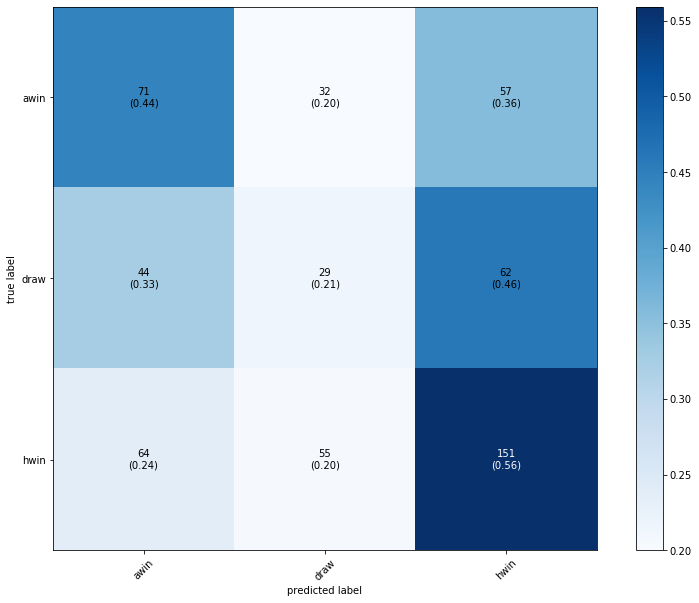

In [23]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=df_cm.values,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                               class_names=cols, figsize=(14,10))
plt.show();

# Other Models

In [24]:
fp = CONSOL_DATA_DIR / 'epl.csv'
df = pd.read_csv(fp, index_col=None)

### Load the Data

In [25]:
PAST_GAMES=8
keeper_cols3, df_all_features = get_n_past_games(df, PAST_GAMES)
# Drop the rows where any of the features have a NaN
df_all_features = df_all_features.dropna(subset=keeper_cols3).reset_index(drop=True)
df_all_features.drop(columns=['h_ftGoals', 'a_ftGoals'], inplace=True)
df_all_features.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,19.0,9.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,11.0,14.0,15.0,16.0,16.0,16.0,18.0,19.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,13.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,7.0,4.0,5.0,10.0,9.0,4.0,8.0,7.0,11.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,1.15,2.43,1.23,1.18,1.16,1.50,1.59,1.32,1.25,1.41,1.64,1.70,3.70,1.66,2.88,1.55,1.17,1.28,1.34,1.49,1.31,1.37,1.28,1.19,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,6.41,3.13,5.29,5.92,6.12,3.74,3.61,4.49,5.15,4.05,3.51,3.44,3.17,3.43,3.06,3.61,6.31,4.89,4.37,3.77,4.67,4.23,4.74,5.74,3.65,3.51,3.25,3.80,3.15,3.41,3.17,3.23,hwin
1,1.0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,11.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,12.0,9.0,9.0,11.0,11.0,10.0,13.0,10.0,12.0,17.0,19.0,9.0,19.0,14.0,25.0,14.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,5.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,5.0,5.0,4.0,4.0,6.0,7.0,8.0,3.0,8.0,9.0,8.0,6.0,12.0,5.0,14.0,8.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,2.40,1.15,2.43,1.23,1.18,1.16,1.50,1.59,3.27,2.50,2.45,2.90,6.26,2.43,2.23,6.07,2.04,1.42,1.46,2.12,1.94,2.78,1.45,1.82,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,3.06,6.41,3.13,

In [26]:
df_all_features.shape

(2367, 161)

### cut out some of the features


In [27]:
keepers = ['h_h_ftGoals-1', 'a_a_ftGoals-1', 'result']
keepers = df_all_features.columns
df_cut = df_all_features[keepers]

In [28]:
df_cut.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,result
0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,19.0,9.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,11.0,14.0,15.0,16.0,16.0,16.0,18.0,19.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,13.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,7.0,4.0,5.0,10.0,9.0,4.0,8.0,7.0,11.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,1.15,2.43,1.23,1.18,1.16,1.50,1.59,1.32,1.25,1.41,1.64,1.70,3.70,1.66,2.88,1.55,1.17,1.28,1.34,1.49,1.31,1.37,1.28,1.19,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,6.41,3.13,5.29,5.92,6.12,3.74,3.61,4.49,5.15,4.05,3.51,3.44,3.17,3.43,3.06,3.61,6.31,4.89,4.37,3.77,4.67,4.23,4.74,5.74,3.65,3.51,3.25,3.80,3.15,3.41,3.17,3.23,hwin
1,1.0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,11.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,12.0,9.0,9.0,11.0,11.0,10.0,13.0,10.0,12.0,17.0,19.0,9.0,19.0,14.0,25.0,14.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,5.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,5.0,5.0,4.0,4.0,6.0,7.0,8.0,3.0,8.0,9.0,8.0,6.0,12.0,5.0,14.0,8.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,2.40,1.15,2.43,1.23,1.18,1.16,1.50,1.59,3.27,2.50,2.45,2.90,6.26,2.43,2.23,6.07,2.04,1.42,1.46,2.12,1.94,2.78,1.45,1.82,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,3.06,6.41,3.13,

In [29]:
df_cut1 = df_cut.copy(deep=True)
X = df_cut1
y = X.pop('result')
X.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8
0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,19.0,9.0,13.0,9.0,15.0,4.0,20.0,6.0,15.0,11.0,14.0,15.0,16.0,16.0,16.0,18.0,19.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,13.0,5.0,7.0,6.0,8.0,1.0,8.0,2.0,7.0,4.0,5.0,10.0,9.0,4.0,8.0,7.0,11.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,1.15,2.43,1.23,1.18,1.16,1.50,1.59,1.32,1.25,1.41,1.64,1.70,3.70,1.66,2.88,1.55,1.17,1.28,1.34,1.49,1.31,1.37,1.28,1.19,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,6.41,3.13,5.29,5.92,6.12,3.74,3.61,4.49,5.15,4.05,3.51,3.44,3.17,3.43,3.06,3.61,6.31,4.89,4.37,3.77,4.67,4.23,4.74,5.74,3.65,3.51,3.25,3.80,3.15,3.41,3.17,3.23
1,1.0,2.0,2.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,0.0,2.0,2.0,4.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,11.0,13.0,16.0,19.0,18.0,15.0,10.0,16.0,12.0,9.0,9.0,11.0,11.0,10.0,13.0,10.0,12.0,17.0,19.0,9.0,19.0,14.0,25.0,14.0,7.0,6.0,14.0,16.0,11.0,16.0,16.0,10.0,5.0,6.0,6.0,9.0,8.0,9.0,8.0,10.0,5.0,5.0,4.0,4.0,6.0,7.0,8.0,3.0,8.0,9.0,8.0,6.0,12.0,5.0,14.0,8.0,4.0,2.0,9.0,7.0,4.0,12.0,10.0,3.0,2.40,1.15,2.43,1.23,1.18,1.16,1.50,1.59,3.27,2.50,2.45,2.90,6.26,2.43,2.23,6.07,2.04,1.42,1.46,2.12,1.94,2.78,1.45,1.82,1.52,1.64,1.93,1.50,2.84,1.79,2.45,2.20,3.06,6.41,3.13,5.29,5.92,6.

In [30]:
y.head()

0    hwin
1    hwin
2    draw
3    hwin
4    draw
Name: result, dtype: object

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
# df1 = df_cut.copy(deep=True)

# X = df1
# y_str = X.pop('result')
# print(y_str[0:10])

from sklearn.preprocessing import LabelEncoder
from skoot.preprocessing import SelectiveMinMaxScaler
#from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline

# label_encoder = LabelEncoder()

# y = label_encoder.fit_transform(y_str)
skf = StratifiedKFold(n_splits=5)
# print(y[0:10])

# # n_games 1140
# # hwin    0.476316
# # draw    0.263158
# # awin    0.260526
# # Name: result, dty

model = GaussianNB(priors=[0.29, 0.26, 0.45])
model = MultinomialNB(class_prior=[0.29, 0.26, 0.45])
model = ComplementNB(class_prior=[0.29, 0.26, 0.45])
# model = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', max_iter=300 )
# model = SGDClassifier(loss='log', class_weight='balanced')
# model = SVC(probability=True, class_weight='balanced', C=1, gamma='auto', kernel='linear')
#model = DecisionTreeClassifier()
# model = RadiusNeighborsClassifier(radius=5.0)

pipe = Pipeline([('scaler', SelectiveMinMaxScaler()),
                ('model', model)])

# pipe = Pipeline([('model', model)])   


scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='balanced_accuracy')

print(scores)
print(np.mean(scores))

[0.45600931 0.4706477  0.46584521 0.48250378 0.45511034]
0.4660232670650514


In [33]:
model.fit(X_train, y_train)
probas = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)
full_df = pd.concat([X_test.reset_index(drop=True), probas, y_test.reset_index(drop=True)], axis=1)
full_df['pred'] = full_df[model.classes_].idxmax(axis=1)
full_df.head()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,awin,draw,hwin,result,pred
0,3.0,3.0,0.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,11.0,12.0,10.0,9.0,11.0,10.0,12.0,23.0,4.0,8.0,4.0,15.0,16.0,7.0,10.0,8.0,13.0,16.0,8.0,5.0,12.0,13.0,8.0,12.0,18.0,18.0,12.0,6.0,9.0,16.0,3.0,12.0,7.0,5.0,0.0,4.0,6.0,3.0,6.0,5.0,1.0,4.0,4.0,3.0,3.0,1.0,5.0,7.0,2.0,5.0,3.0,1.0,3.0,4.0,2.0,3.0,3.0,6.0,7.0,2.0,5.0,9.0,2.0,2.0,1.29,1.34,1.81,1.38,1.81,1.44,1.31,1.30,4.47,5.86,13.10,3.28,3.80,7.00,3.69,3.73,2.61,1.90,2.20,4.21,2.03,2.87,6.80,8.91,2.00,1.96,1.61,1.99,2.23,1.59,2.61,3.40,5.57,5.14,3.59,4.82,3.67,4.45,5.36,5.53,3.38,3.99,6.39,3.19,3.34,4.23,3.34,3.35,3.09,3.48,3.25,3.46,3.27,3.29,4.33,4.69,3.41,3.51,3.92,3.41,3.43,3.90,3.33,3.46,3.618787e-07,0.000018,9.999819e-01,hwin,hwin
1,2.0,4.0,2.0,4.0,2.0,1.0,3.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,2.0,3.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,2.0,0.0,1.0,13.0,12.0,12.0,11.0,13.0,17.0,13.0,20.0,4.0,7.0,11.0,17.0,4.0,13.0,15.0,10.0,16.0,14.0,12.0,16.0,23.0,12.0,15.0,15.0,17.0,8.0,12.0,9.0,14.0,9.0,14.0,5.0,6.0,6.0,6.0,5.0,8.0,7.0,8.0,7.0,1.0,4.0,5.0,10.0,2.0,9.0,7.0,4.0,11.0,6.0,6.0,6.0,12.0,8.0,8.0,6.0,11.0,4.0,5.0,5.0,6.0,6.0,6.0,4.0,1.29,1.42,1.43,1.52,4.16,1.27,1.32,1.45,7.69,14.70,3.03,3.00,4.18,4.65,13.62,3.28,2.23,1.76,6.31,1.80,2.16,4.43,2.20,7.90,1.72,2.

In [34]:
full_df.tail()

,h_h_ftGoals-1,h_h_ftGoals-2,h_h_ftGoals-3,h_h_ftGoals-4,h_h_ftGoals-5,h_h_ftGoals-6,h_h_ftGoals-7,h_h_ftGoals-8,a_a_ftGoals-1,a_a_ftGoals-2,a_a_ftGoals-3,a_a_ftGoals-4,a_a_ftGoals-5,a_a_ftGoals-6,a_a_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-1,a_h_ftGoals-2,a_h_ftGoals-3,a_h_ftGoals-4,a_h_ftGoals-5,a_h_ftGoals-6,a_h_ftGoals-7,a_h_ftGoals-8,h_a_ftGoals-1,h_a_ftGoals-2,h_a_ftGoals-3,h_a_ftGoals-4,h_a_ftGoals-5,h_a_ftGoals-6,h_a_ftGoals-7,h_a_ftGoals-8,h_h_shots-1,h_h_shots-2,h_h_shots-3,h_h_shots-4,h_h_shots-5,h_h_shots-6,h_h_shots-7,h_h_shots-8,a_a_shots-1,a_a_shots-2,a_a_shots-3,a_a_shots-4,a_a_shots-5,a_a_shots-6,a_a_shots-7,a_a_shots-8,a_h_shots-1,a_h_shots-2,a_h_shots-3,a_h_shots-4,a_h_shots-5,a_h_shots-6,a_h_shots-7,a_h_shots-8,h_a_shots-1,h_a_shots-2,h_a_shots-3,h_a_shots-4,h_a_shots-5,h_a_shots-6,h_a_shots-7,h_a_shots-8,h_h_shotsOnTarget-1,h_h_shotsOnTarget-2,h_h_shotsOnTarget-3,h_h_shotsOnTarget-4,h_h_shotsOnTarget-5,h_h_shotsOnTarget-6,h_h_shotsOnTarget-7,h_h_shotsOnTarget-8,a_a_shotsOnTarget-1,a_a_shotsOnTarget-2,a_a_shotsOnTarget-3,a_a_shotsOnTarget-4,a_a_shotsOnTarget-5,a_a_shotsOnTarget-6,a_a_shotsOnTarget-7,a_a_shotsOnTarget-8,a_h_shotsOnTarget-1,a_h_shotsOnTarget-2,a_h_shotsOnTarget-3,a_h_shotsOnTarget-4,a_h_shotsOnTarget-5,a_h_shotsOnTarget-6,a_h_shotsOnTarget-7,a_h_shotsOnTarget-8,h_a_shotsOnTarget-1,h_a_shotsOnTarget-2,h_a_shotsOnTarget-3,h_a_shotsOnTarget-4,h_a_shotsOnTarget-5,h_a_shotsOnTarget-6,h_a_shotsOnTarget-7,h_a_shotsOnTarget-8,h_h_oddsWinMean-1,h_h_oddsWinMean-2,h_h_oddsWinMean-3,h_h_oddsWinMean-4,h_h_oddsWinMean-5,h_h_oddsWinMean-6,h_h_oddsWinMean-7,h_h_oddsWinMean-8,a_a_oddsWinMean-1,a_a_oddsWinMean-2,a_a_oddsWinMean-3,a_a_oddsWinMean-4,a_a_oddsWinMean-5,a_a_oddsWinMean-6,a_a_oddsWinMean-7,a_a_oddsWinMean-8,a_h_oddsWinMean-1,a_h_oddsWinMean-2,a_h_oddsWinMean-3,a_h_oddsWinMean-4,a_h_oddsWinMean-5,a_h_oddsWinMean-6,a_h_oddsWinMean-7,a_h_oddsWinMean-8,h_a_oddsWinMean-1,h_a_oddsWinMean-2,h_a_oddsWinMean-3,h_a_oddsWinMean-4,h_a_oddsWinMean-5,h_a_oddsWinMean-6,h_a_oddsWinMean-7,h_a_oddsWinMean-8,h_h_oddsDrawMean-1,h_h_oddsDrawMean-2,h_h_oddsDrawMean-3,h_h_oddsDrawMean-4,h_h_oddsDrawMean-5,h_h_oddsDrawMean-6,h_h_oddsDrawMean-7,h_h_oddsDrawMean-8,a_a_oddsDrawMean-1,a_a_oddsDrawMean-2,a_a_oddsDrawMean-3,a_a_oddsDrawMean-4,a_a_oddsDrawMean-5,a_a_oddsDrawMean-6,a_a_oddsDrawMean-7,a_a_oddsDrawMean-8,a_h_oddsDrawMean-1,a_h_oddsDrawMean-2,a_h_oddsDrawMean-3,a_h_oddsDrawMean-4,a_h_oddsDrawMean-5,a_h_oddsDrawMean-6,a_h_oddsDrawMean-7,a_h_oddsDrawMean-8,h_a_oddsDrawMean-1,h_a_oddsDrawMean-2,h_a_oddsDrawMean-3,h_a_oddsDrawMean-4,h_a_oddsDrawMean-5,h_a_oddsDrawMean-6,h_a_oddsDrawMean-7,h_a_oddsDrawMean-8,awin,draw,hwin,result,pred
469,1.0,1.0,1.0,2.0,3.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,1.0,1.0,4.0,2.0,12.0,23.0,14.0,27.0,20.0,21.0,17.0,21.0,5.0,14.0,4.0,3.0,16.0,4.0,6.0,6.0,9.0,9.0,6.0,30.0,15.0,5.0,8.0,3.0,11.0,16.0,17.0,3.0,14.0,7.0,14.0,19.0,4.0,6.0,4.0,11.0,8.0,5.0,7.0,12.0,3.0,5.0,0.0,3.0,7.0,0.0,3.0,1.0,2.0,1.0,2.0,4.0,4.0,1.0,2.0,1.0,3.0,5.0,5.0,0.0,7.0,3.0,10.0,6.0,2.23,1.27,2.36,1.30,1.37,1.28,1.29,1.17,28.00,4.76,5.19,16.27,4.49,20.10,3.97,5.63,2.56,2.63,2.88,2.49,3.22,10.65,2.64,2.35,1.50,1.90,1.86,5.63,3.38,1.61,1.62,2.62,3.51,5.83,3.29,5.54,4.89,5.90,5.65,7.45,11.57,3.40,3.52,7.18,3.25,7.59,3.33,3.85,3.02,3.15,3.12,3.08,3.16,5.46,3.05,3.05,4.23,3.44,3.61,4.14,3.24,3.96,3.76,3.40,2.738304e-14,5.988240e-10,1.000000,draw,hwin
470,0.0,1.0,2.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,3.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,3.0,12.0,15.0,24.0,4.0,17.0,17.0,10.0,12.0,14.0,19.0,11.0,17.0,8.0,13.0,10.0,6.0,11.0,23.0,15.0,11.0,13.0,11.0,14.0,12.0,4.0,7.0,12.0,5.0,9.0,3.0,11.0,6.0,6.0,5.0,7.0,0.0,9.0,12.0,4.0,8.0,6.0,12.0,6.0,10.0,3.0,6.0,4.0,2.0,10.0,12.0,9.0,5.0,8.0,8.0,7.0,8.0,2.0,2.0,9.0,2.0,5.0,2.0,3.0,4.0,3.59,2.01,1.82,2.11,3.12,2.22,3.39,2.28,4.51,2.86,8.54,3.61,6.04,3.59,5.39,10.65,4.74,2.15,2.26,2.69,1.83,5.50,1.70,2.07,

In [35]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(full_df['result'], full_df['pred']))
df_cm

,0,1,2
0,96,0,35
1,58,2,65
2,61,2,155


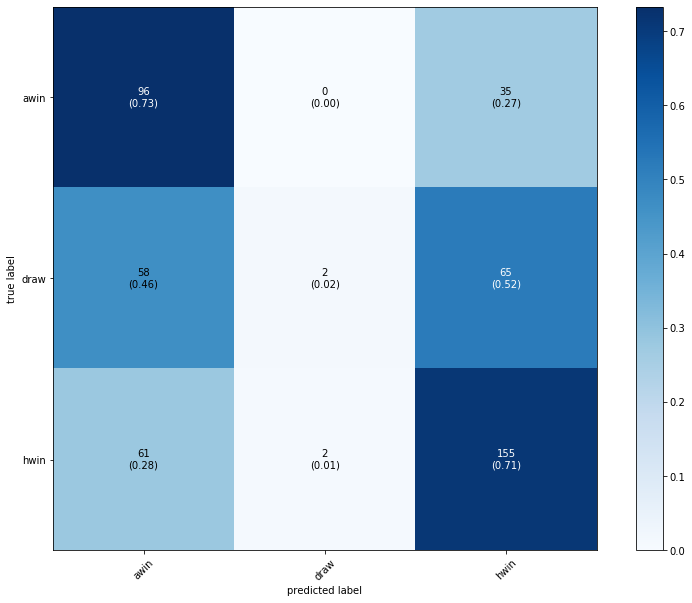

In [36]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=df_cm.values,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                               class_names=model.classes_, figsize=(14,10))
plt.show();